
## Modelo de Regresión con Support Vector Regression (SVR)
 
Este notebook implementa un modelo de Support Vector Regression para predecir el consumo energético.
El objetivo es desarrollar un modelo robusto capaz de realizar predicciones precisas utilizando técnicas de optimización bayesiana y validación cruzada.

## Estructura del Análisis
1. **Preparación de Datos**: Carga y separación de datasets de entrenamiento y prueba
2. **Preprocesamiento**: Escalado de características para SVR
3. **Modelo Básico**: Implementación inicial con parámetros por defecto
4. **Optimización**: Búsqueda bayesiana de hiperparámetros
5. **Evaluación**: Métricas completas en entrenamiento y prueba
6. **Comparación**: Análisis de diferentes kernels
7. **Visualización**: Gráficos de rendimiento y residuos
8. **Persistencia**: Guardado del modelo y resultados

## Importación de Librerías
Se importan todas las dependencias necesarias para el análisis de regresión

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import joblib
import warnings
import os

warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Preparación de Datos
 
A diferencia de un enfoque tradicional de división aleatoria, utilizamos datasets predefinidos de entrenamiento y prueba. Esto garantiza:
- Evaluación consistente entre modelos
- Comparabilidad de resultados
- Simulación de un escenario real donde los datos de prueba son completamente nuevos

Carga de datasets preprocesados
Los datos ya han pasado por OneHotEncoding y limpieza previa

In [2]:
# 1. CARGAR Y PREPARAR LOS DATOS
# Cargar ambos datasets
train_df = pd.read_csv('../data/processed/energy_data_processed.csv')
test_df = pd.read_csv('../data/processed/energy_data_processed_test.csv')

print(f"Dataset de entrenamiento cargado: {train_df.shape[0]} filas, {train_df.shape[1]} columnas")
print(f"Dataset de prueba cargado: {test_df.shape[0]} filas, {test_df.shape[1]} columnas")

Dataset de entrenamiento cargado: 1000 filas, 10 columnas
Dataset de prueba cargado: 100 filas, 10 columnas


## 2. Separación de Variables
 
Se separan las características (X) de la variable objetivo (y) para ambos conjuntos.
La variable objetivo 'Energy Consumption' es lo que queremos predecir.

Separación para el dataset de entrenamiento

In [3]:
# 2. SEPARAR CARACTERÍSTICAS Y VARIABLE OBJETIVO
# Para el dataset de entrenamiento
y_train = train_df['Energy Consumption']
X_train = train_df.drop('Energy Consumption', axis=1)

# Para el dataset de prueba
y_test = test_df['Energy Consumption']
X_test = test_df.drop('Energy Consumption', axis=1)

print(f"Forma del dataset de entrenamiento: {X_train.shape}")
print(f"Forma del dataset de prueba: {X_test.shape}")
print(f"Variable objetivo: {y_train.name}")
print(f"\nCaracterísticas disponibles:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2d}. {col}")

Forma del dataset de entrenamiento: (1000, 9)
Forma del dataset de prueba: (100, 9)
Variable objetivo: Energy Consumption

Características disponibles:
   1. Square Footage
   2. Number of Occupants
   3. Appliances Used
   4. Average Temperature
   5. Building Type_Commercial
   6. Building Type_Industrial
   7. Building Type_Residential
   8. Day of Week_Weekday
   9. Day of Week_Weekend


## 3. Preprocesamiento - Escalado de Características
 
SVR es sensible a la escala de las características. El StandardScaler normaliza cada característica para que tenga media 0 y desviación estándar 1.
 
**Importante**: Se ajusta (fit) solo con datos de entrenamiento y se transforma tanto entrenamiento como prueba para evitar data leakage.

Inicialización del escalador

In [4]:
# 3. ESCALADO DE CARACTERÍSTICAS
scaler = StandardScaler()
# Ajuste con datos de entrenamiento y transformación
X_train_scaled = scaler.fit_transform(X_train)
# Solo transformación para datos de prueba (sin fit)
X_test_scaled = scaler.transform(X_test)

print("✅ Escalado completado")
print(f"Forma X_train_scaled: {X_train_scaled.shape}")
print(f"Forma X_test_scaled: {X_test_scaled.shape}")

# Verificación del escalado (debe ser ~0 mean, ~1 std para entrenamiento)
print(f"\nVerificación del escalado (X_train):")
print(f"Media promedio: {np.mean(X_train_scaled.mean(axis=0)):.6f}")
print(f"Desviación estándar promedio: {np.mean(X_train_scaled.std(axis=0)):.6f}")

✅ Escalado completado
Forma X_train_scaled: (1000, 9)
Forma X_test_scaled: (100, 9)

Verificación del escalado (X_train):
Media promedio: 0.000000
Desviación estándar promedio: 1.000000


## 4. Modelo SVR Básico (Línea Base)

Implementamos primero un modelo SVR con parámetros por defecto para establecer una línea base. Utilizamos kernel RBF que es efectivo para relaciones no lineales.

In [5]:
# 4. MODELO SVR BÁSICO (parámetros por defecto)
print("\n=== SVR BÁSICO ===")
svr_basic = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_basic.fit(X_train_scaled, y_train)

# Predicciones básicas (solo para prueba, para comparar)
y_pred_basic = svr_basic.predict(X_test_scaled)

# Métricas de evaluación básicas
mse_basic = mean_squared_error(y_test, y_pred_basic)
rmse_basic = np.sqrt(mse_basic)
r2_basic = r2_score(y_test, y_pred_basic)
mae_basic = mean_absolute_error(y_test, y_pred_basic)

print(f"Métricas del modelo básico:")
print(f"MSE: {mse_basic:.4f}")
print(f"RMSE: {rmse_basic:.4f}")
print(f"R²: {r2_basic:.4f}")
print(f"MAE: {mae_basic:.4f}")


=== SVR BÁSICO ===


Métricas del modelo básico:
MSE: 633288.3944
RMSE: 795.7942
R²: 0.0771
MAE: 647.7831


## 5. Optimización de Hiperparámetros con Búsqueda Bayesiana
 
Utilizamos BayesSearchCV en lugar de GridSearchCV por su eficiencia.
La optimización bayesiana es más inteligente: usa resultados previos para elegir qué hiperparámetros probar a continuación.
 
**Parámetros a optimizar:**
- **C**: Parámetro de regularización (0.1 a 100, escala logarítmica)
- **gamma**: Coeficiente del kernel ('scale', 'auto', valores fijos)
- **kernel**: Tipo de kernel ('rbf', 'poly')
- **epsilon**: Tolerancia de error (0.01 a 0.2)


Importación de la librería de optimización bayesiana

In [6]:
# 5. OPTIMIZACIÓN CON BAYESIAN SEARCH
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

print("=== OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS ===")

# Configuración del espacio de búsqueda
search_space = {
    'C': Real(0.1, 100, prior='log-uniform'),  # Escala logarítmica para mejor exploración
    'gamma': Categorical(['scale', 'auto', 0.001, 0.01, 0.1]),
    'kernel': Categorical(['rbf', 'poly']),  # Kernels más efectivos para este problema
    'epsilon': Real(0.01, 0.2)  # Tolerancia de error
}

# Configuración del optimizador bayesiano
bayes_search = BayesSearchCV(
    estimator=SVR(),
    search_spaces=search_space,
    n_iter=30,  # 30 evaluaciones inteligentes (vs ~1000 en grid search)
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='neg_mean_squared_error',  # Métrica a optimizar
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1,  # Mostrar progreso
    random_state=42  # Reproducibilidad
)

print("Iniciando búsqueda bayesiana... (esto puede tomar varios minutos)")
bayes_search.fit(X_train_scaled, y_train)

print(f"\n✅ Optimización completada!")
print(f"Mejores parámetros encontrados: {bayes_search.best_params_}")
print(f"Mejor score de validación cruzada: {-bayes_search.best_score_:.4f}")


=== OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS ===
Iniciando búsqueda bayesiana... (esto puede tomar varios minutos)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

## 6. Evaluación del Modelo Optimizado
 
Evaluamos el modelo optimizado en ambos conjuntos (entrenamiento y prueba) para detectar posibles problemas de overfitting o underfitting.

In [7]:
# 6. MODELO OPTIMIZADO
print("=== EVALUACIÓN DEL MODELO OPTIMIZADO ===")
svr_optimized = bayes_search.best_estimator_

# Predicciones para entrenamiento y prueba
y_pred_train_optimized = svr_optimized.predict(X_train_scaled)
y_pred_test_optimized = svr_optimized.predict(X_test_scaled)

# Métricas para entrenamiento
mse_train_opt = mean_squared_error(y_train, y_pred_train_optimized)
rmse_train_opt = np.sqrt(mse_train_opt)
r2_train_opt = r2_score(y_train, y_pred_train_optimized)
mae_train_opt = mean_absolute_error(y_train, y_pred_train_optimized)

# Métricas para prueba
mse_test_opt = mean_squared_error(y_test, y_pred_test_optimized)
rmse_test_opt = np.sqrt(mse_test_opt)
r2_test_opt = r2_score(y_test, y_pred_test_optimized)
mae_test_opt = mean_absolute_error(y_test, y_pred_test_optimized)

print(f"\n=== MODELO OPTIMIZADO (ENTRENAMIENTO) ===")
print(f"MSE: {mse_train_opt:.4f}")
print(f"RMSE: {rmse_train_opt:.4f}")
print(f"R²: {r2_train_opt:.4f}")
print(f"MAE: {mae_train_opt:.4f}")

print(f"\n=== MODELO OPTIMIZADO (PRUEBA) ===")
print(f"MSE: {mse_test_opt:.4f}")
print(f"RMSE: {rmse_test_opt:.4f}")
print(f"R²: {r2_test_opt:.4f}")
print(f"MAE: {mae_test_opt:.4f}")

# Análisis de overfitting
diff_r2 = r2_train_opt - r2_test_opt
print(f"\nANÁLISIS DE OVERFITTING:")
print(f"  Diferencia R² (train - test): {diff_r2:.4f}")
if diff_r2 < 0.1:
    print("  ✅ Modelo bien balanceado (bajo overfitting)")
elif diff_r2 < 0.2:
    print("  ⚠️  Overfitting moderado")
else:
    print("  ❌ Overfitting significativo")

=== EVALUACIÓN DEL MODELO OPTIMIZADO ===

=== MODELO OPTIMIZADO (ENTRENAMIENTO) ===
MSE: 475.5602
RMSE: 21.8073
R²: 0.9995
MAE: 15.3973

=== MODELO OPTIMIZADO (PRUEBA) ===
MSE: 487.4244
RMSE: 22.0777
R²: 0.9993
MAE: 16.2124

ANÁLISIS DE OVERFITTING:
  Diferencia R² (train - test): 0.0002
  ✅ Modelo bien balanceado (bajo overfitting)


## 7. Validación Cruzada Adicional
 
Realizamos validación cruzada de 5 pliegues en el conjunto de entrenamiento para obtener una estimación más robusta del rendimiento del modelo.

Validación cruzada de 5 pliegues

In [8]:
# Validación cruzada de 5 pliegues
cv_scores = cross_val_score(
    svr_optimized, 
    X_train_scaled, 
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
)

# Conversión a RMSE y cálculo de estadísticas
cv_rmse_scores = np.sqrt(-cv_scores)
cv_rmse_mean = cv_rmse_scores.mean()
cv_rmse_std = cv_rmse_scores.std()

print(f"VALIDACIÓN CRUZADA (5 pliegues):")
print(f"  RMSE promedio: {cv_rmse_mean:.4f}")
print(f"  Desviación estándar: {cv_rmse_std:.4f}")
print(f"  Intervalo de confianza: {cv_rmse_mean:.4f} ± {cv_rmse_std * 2:.4f}")
print(f"  Scores individuales: {cv_rmse_scores.round(4)}")

VALIDACIÓN CRUZADA (5 pliegues):
  RMSE promedio: 35.8184
  Desviación estándar: 2.1142
  Intervalo de confianza: 35.8184 ± 4.2285
  Scores individuales: [35.7268 37.3691 34.3023 38.8164 32.8773]


## 8. Guardado de Resultados en CSV
 
Guardamos las predicciones y errores en archivos CSV para análisis posterior y comparación con otros modelos.

In [9]:
# 7. GUARDAR RESULTADOS EN CSV

print("=== GUARDADO DE RESULTADOS ===")
# Resultados de entrenamiento
train_results = pd.DataFrame({
    'Valores_Reales': y_train.values,
    'Predicciones': y_pred_train_optimized,
    'Diferencia': y_train.values - y_pred_train_optimized,
    'Error_Absoluto': np.abs(y_train.values - y_pred_train_optimized),
    'Error_Cuadratico': (y_train.values - y_pred_train_optimized) ** 2
})
# Agregar metadatos al CSV de entrenamiento
train_results.to_csv('../data/results/svr_predictions_train.csv', index=False)
print("✅ Predicciones de entrenamiento guardadas en 'svr_predictions_train.csv'")

# Resultados del conjunto de prueba
test_results = pd.DataFrame({
    'Valores_Reales': y_test.values,
    'Predicciones': y_pred_test_optimized,
    'Diferencia': y_test.values - y_pred_test_optimized,
    'Error_Absoluto': np.abs(y_test.values - y_pred_test_optimized),
    'Error_Cuadratico': (y_test.values - y_pred_test_optimized) ** 2
})

test_results.to_csv('../data/results/svr_predictions_test.csv', index=False)
print("✅ Predicciones de prueba guardadas en 'svr_predictions_test.csv'")

# Guardado de métricas resumen
metrics_summary = pd.DataFrame({
    'Conjunto': ['Entrenamiento', 'Prueba', 'CV_Media', 'CV_Std'],
    'MSE': [mse_train_opt, mse_test_opt, cv_rmse_mean**2, np.nan],
    'RMSE': [rmse_train_opt, rmse_test_opt, cv_rmse_mean, cv_rmse_std],
    'R2': [r2_train_opt, r2_test_opt, np.nan, np.nan],
    'MAE': [mae_train_opt, mae_test_opt, np.nan, np.nan]
})

metrics_summary.to_csv('../data/results/svr_metrics_summary.csv', index=False)
print("✅ Resumen de métricas guardado en 'svr_metrics_summary.csv'")


=== GUARDADO DE RESULTADOS ===
✅ Predicciones de entrenamiento guardadas en 'svr_predictions_train.csv'
✅ Predicciones de prueba guardadas en 'svr_predictions_test.csv'
✅ Resumen de métricas guardado en 'svr_metrics_summary.csv'


## 9. Comparación de Kernels
 
Evaluamos diferentes tipos de kernels para entender cuál es más apropiado para nuestro problema específico. Esto nos ayuda a validar la elección del kernel en nuestro modelo optimizado.

In [10]:
# 8. COMPARACIÓN DE KERNELS
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    print(f"Evaluando kernel: {kernel}...")
    
    # Modelo con kernel específico
    svr_kernel = SVR(kernel=kernel, C=1.0, gamma='scale')
    svr_kernel.fit(X_train_scaled, y_train)
    y_pred_kernel = svr_kernel.predict(X_test_scaled)
    
    # Cálculo de métricas
    mse_kernel = mean_squared_error(y_test, y_pred_kernel)
    rmse_kernel = np.sqrt(mse_kernel)
    r2_kernel = r2_score(y_test, y_pred_kernel)
    mae_kernel = mean_absolute_error(y_test, y_pred_kernel)
    
    # Almacenamiento de resultados
    kernel_results[kernel] = {
        'MSE': mse_kernel, 
        'RMSE': rmse_kernel,
        'R²': r2_kernel,
        'MAE': mae_kernel
    }
    
    print(f"  {kernel.upper():8s} - MSE: {mse_kernel:.4f}, RMSE: {rmse_kernel:.4f}, R²: {r2_kernel:.4f}")

# Identificar el mejor kernel por R²
best_kernel = max(kernel_results.keys(), key=lambda k: kernel_results[k]['R²'])
print(f"\n🏆 Mejor kernel por R²: {best_kernel.upper()} (R² = {kernel_results[best_kernel]['R²']:.4f})")


Evaluando kernel: linear...
  LINEAR   - MSE: 728.6233, RMSE: 26.9930, R²: 0.9989
Evaluando kernel: rbf...
  RBF      - MSE: 633288.3944, RMSE: 795.7942, R²: 0.0771
Evaluando kernel: poly...
  POLY     - MSE: 621850.1194, RMSE: 788.5747, R²: 0.0938
Evaluando kernel: sigmoid...
  SIGMOID  - MSE: 559055.6508, RMSE: 747.7002, R²: 0.1853

🏆 Mejor kernel por R²: LINEAR (R² = 0.9989)


## 10. Visualizaciones Completas
 
Creamos visualizaciones comprehensivas para entender el comportamiento del modelo:
- Predicciones vs valores reales
- Análisis de residuos
- Comparación de kernels
 
Generamos gráficos separados para entrenamiento y prueba para detectar overfitting visual.

=== GENERACIÓN DE VISUALIZACIONES ===


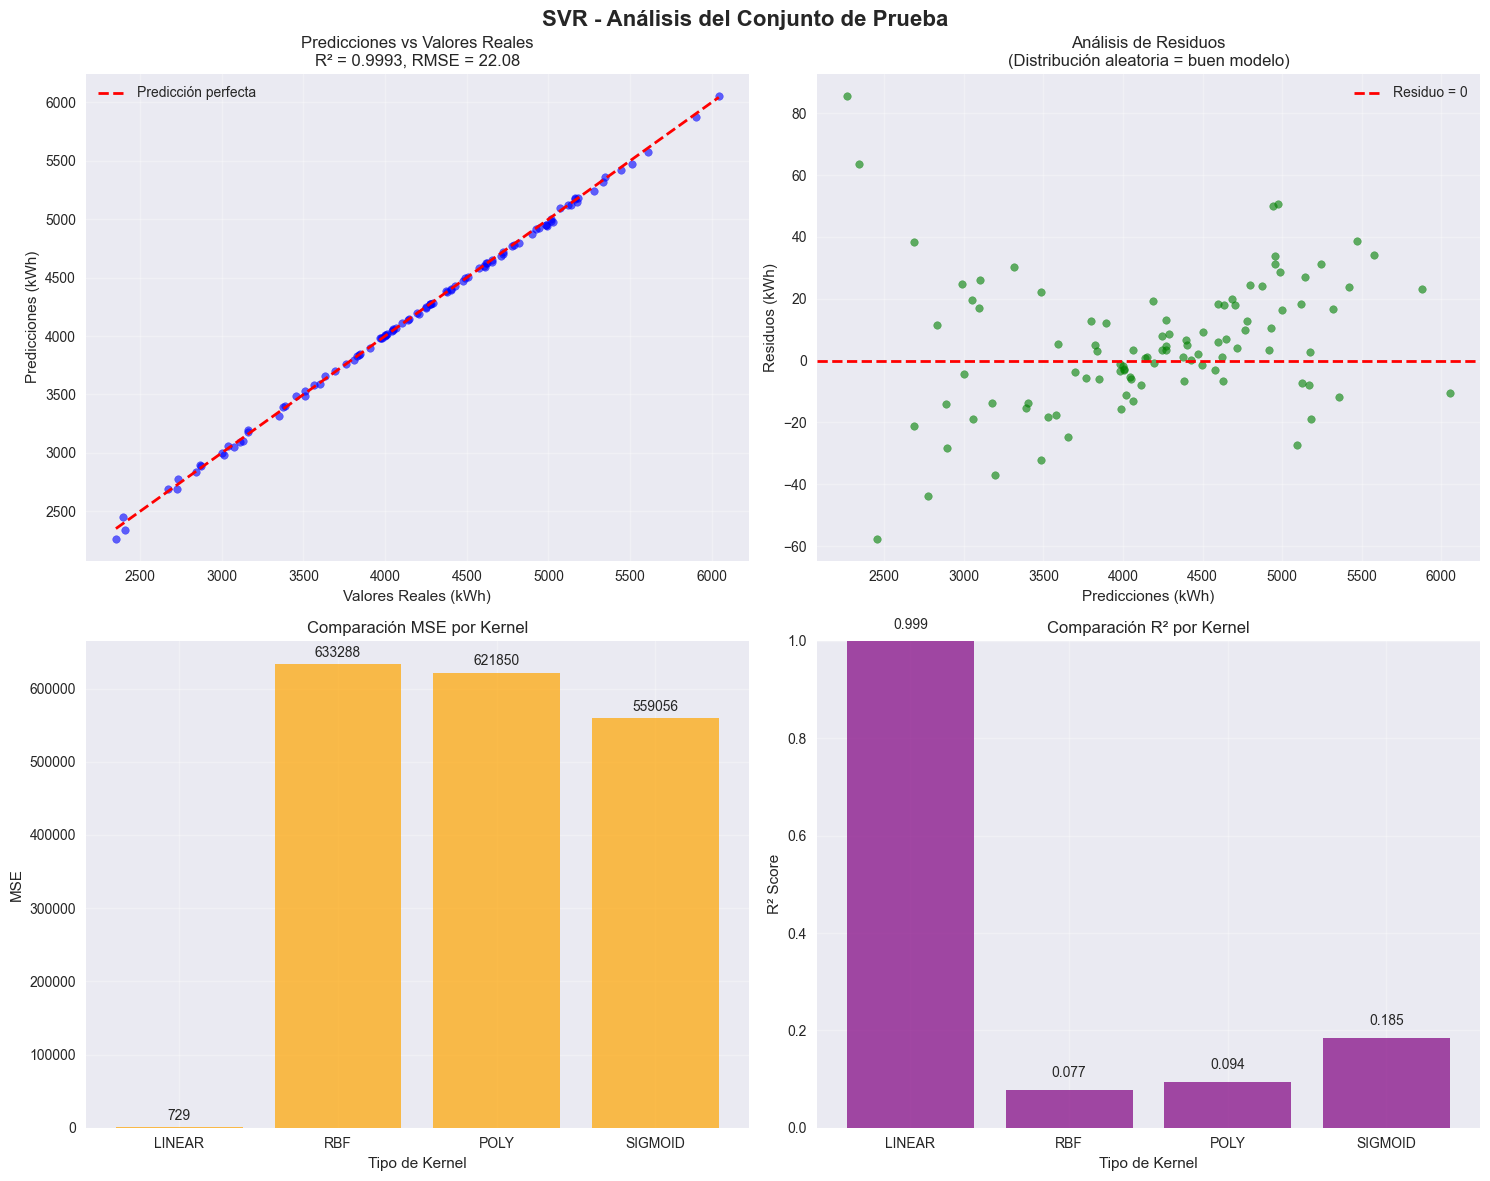

📊 Gráficos de prueba guardados en: ../data/figures/svr_analysis_test.png


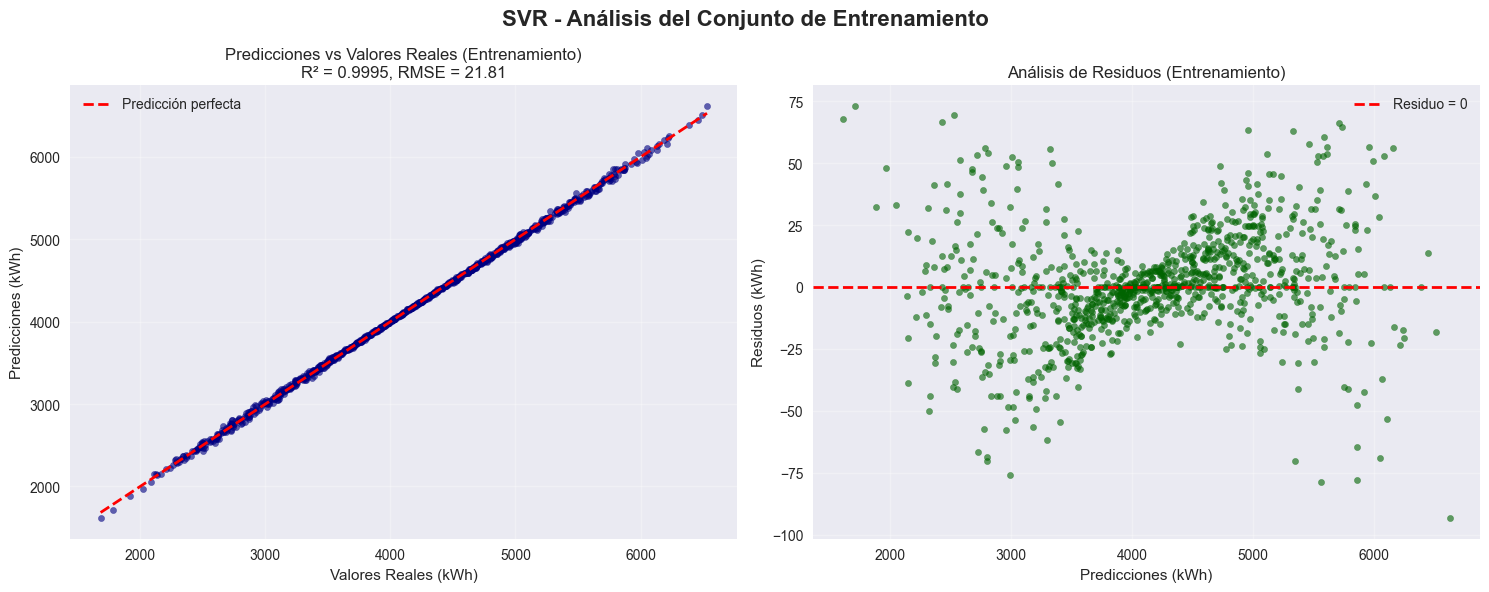

📊 Gráficos de entrenamiento guardados en: ../data/figures/svr_analysis_train.png


In [11]:
# 9. VISUALIZACIONES
print("=== GENERACIÓN DE VISUALIZACIONES ===")
output_dir = "../data/figures/"

# ============= GRÁFICOS PARA CONJUNTO DE PRUEBA =============
fig_test, axes_test = plt.subplots(2, 2, figsize=(15, 12))
fig_test.suptitle('SVR - Análisis del Conjunto de Prueba', fontsize=16, fontweight='bold')

# Gráfico 1: Valores reales vs predicciones (prueba)
axes_test[0,0].scatter(y_test, y_pred_test_optimized, alpha=0.6, color='blue', s=30)
axes_test[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
axes_test[0,0].set_xlabel('Valores Reales (kWh)')
axes_test[0,0].set_ylabel('Predicciones (kWh)')
axes_test[0,0].set_title(f'Predicciones vs Valores Reales\nR² = {r2_test_opt:.4f}, RMSE = {rmse_test_opt:.2f}')
axes_test[0,0].grid(True, alpha=0.3)
axes_test[0,0].legend()

# Gráfico 2: Análisis de residuos (prueba)
residuos_test = y_test - y_pred_test_optimized
axes_test[0,1].scatter(y_pred_test_optimized, residuos_test, alpha=0.6, color='green', s=30)
axes_test[0,1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes_test[0,1].set_xlabel('Predicciones (kWh)')
axes_test[0,1].set_ylabel('Residuos (kWh)')
axes_test[0,1].set_title('Análisis de Residuos\n(Distribución aleatoria = buen modelo)')
axes_test[0,1].grid(True, alpha=0.3)
axes_test[0,1].legend()

# Gráfico 3: Comparación MSE por kernel
kernel_names = list(kernel_results.keys())
mse_values = [kernel_results[k]['MSE'] for k in kernel_names]
bars1 = axes_test[1,0].bar(np.arange(len(kernel_names)), mse_values, alpha=0.7, color='orange')
axes_test[1,0].set_xlabel('Tipo de Kernel')
axes_test[1,0].set_ylabel('MSE')
axes_test[1,0].set_title('Comparación MSE por Kernel')
axes_test[1,0].set_xticks(np.arange(len(kernel_names)))
axes_test[1,0].set_xticklabels([k.upper() for k in kernel_names])
axes_test[1,0].grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, value in zip(bars1, mse_values):
    axes_test[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(mse_values)*0.01,
                       f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# Gráfico 4: Comparación R² por kernel
r2_values = [kernel_results[k]['R²'] for k in kernel_names]
bars2 = axes_test[1,1].bar(np.arange(len(kernel_names)), r2_values, alpha=0.7, color='purple')
axes_test[1,1].set_xlabel('Tipo de Kernel')
axes_test[1,1].set_ylabel('R² Score')
axes_test[1,1].set_title('Comparación R² por Kernel')
axes_test[1,1].set_xticks(np.arange(len(kernel_names)))
axes_test[1,1].set_xticklabels([k.upper() for k in kernel_names])
axes_test[1,1].grid(True, alpha=0.3)
axes_test[1,1].set_ylim(0, 1)

# Agregar valores en las barras
for bar, value in zip(bars2, r2_values):
    axes_test[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
fig_test.savefig(f"{output_dir}svr_analysis_test.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Gráficos de prueba guardados en: {output_dir}svr_analysis_test.png")

# ============= GRÁFICOS PARA CONJUNTO DE ENTRENAMIENTO =============
fig_train, axes_train = plt.subplots(1, 2, figsize=(15, 6))
fig_train.suptitle('SVR - Análisis del Conjunto de Entrenamiento', fontsize=16, fontweight='bold')

# Gráfico 1: Valores reales vs predicciones (entrenamiento)
axes_train[0].scatter(y_train, y_pred_train_optimized, alpha=0.6, color='navy', s=20)
axes_train[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Predicción perfecta')
axes_train[0].set_xlabel('Valores Reales (kWh)')
axes_train[0].set_ylabel('Predicciones (kWh)')
axes_train[0].set_title(f'Predicciones vs Valores Reales (Entrenamiento)\nR² = {r2_train_opt:.4f}, RMSE = {rmse_train_opt:.2f}')
axes_train[0].grid(True, alpha=0.3)
axes_train[0].legend()

# Gráfico 2: Análisis de residuos (entrenamiento)
residuos_train = y_train - y_pred_train_optimized
axes_train[1].scatter(y_pred_train_optimized, residuos_train, alpha=0.6, color='darkgreen', s=20)
axes_train[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes_train[1].set_xlabel('Predicciones (kWh)')
axes_train[1].set_ylabel('Residuos (kWh)')
axes_train[1].set_title('Análisis de Residuos (Entrenamiento)')
axes_train[1].grid(True, alpha=0.3)
axes_train[1].legend()

plt.tight_layout()
fig_train.savefig(f"{output_dir}svr_analysis_train.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Gráficos de entrenamiento guardados en: {output_dir}svr_analysis_train.png")



## 11. Tabla Resumen Completa
 
Compilamos todos los resultados en una tabla comparativa clara que muestra la evolución del rendimiento desde el modelo básico hasta el optimizado.


In [12]:
# 10. TABLA RESUMEN DE RESULTADOS
# Creación de la tabla resumen
resumen = pd.DataFrame({
    'Modelo': [
        'SVR Básico (Prueba)', 
        'SVR Optimizado (Entrenamiento)', 
        'SVR Optimizado (Prueba)',
        'Validación Cruzada (Media)',
        f'Mejor Kernel: {best_kernel.upper()}'
    ],
    'MSE': [
        mse_basic, 
        mse_train_opt, 
        mse_test_opt,
        cv_rmse_mean**2,
        kernel_results[best_kernel]['MSE']
    ],
    'RMSE': [
        rmse_basic, 
        rmse_train_opt, 
        rmse_test_opt,
        cv_rmse_mean,
        kernel_results[best_kernel]['RMSE']
    ],
    'R²': [
        r2_basic, 
        r2_train_opt, 
        r2_test_opt,
        np.nan,  # No aplica para CV
        kernel_results[best_kernel]['R²']
    ],
    'MAE': [
        mae_basic, 
        mae_train_opt, 
        mae_test_opt,
        np.nan,  # No aplica para CV
        kernel_results[best_kernel]['MAE']
    ]
})

# Formateo y visualización de la tabla
resumen_formatted = resumen.round(4)
print(resumen_formatted.to_string(index=False))

# Guardado de la tabla resumen
resumen.to_csv('../data/results/svr_complete_summary.csv', index=False)
print(f"\n✅ Tabla resumen guardada en: '../data/results/svr_complete_summary.csv'")

# Análisis de mejora
mejora_r2 = ((r2_test_opt - r2_basic) / r2_basic) * 100
mejora_rmse = ((rmse_basic - rmse_test_opt) / rmse_basic) * 100

print(f"\n🎯 ANÁLISIS DE MEJORA:")
print(f"   Mejora en R²: +{mejora_r2:.1f}% ({r2_basic:.4f} → {r2_test_opt:.4f})")
print(f"   Mejora en RMSE: -{mejora_rmse:.1f}% ({rmse_basic:.2f} → {rmse_test_opt:.2f})")


                        Modelo         MSE     RMSE     R²      MAE
           SVR Básico (Prueba) 633288.3944 795.7942 0.0771 647.7831
SVR Optimizado (Entrenamiento)    475.5602  21.8073 0.9995  15.3973
       SVR Optimizado (Prueba)    487.4244  22.0777 0.9993  16.2124
    Validación Cruzada (Media)   1282.9548  35.8184    NaN      NaN
          Mejor Kernel: LINEAR    728.6233  26.9930 0.9989  22.1826

✅ Tabla resumen guardada en: '../data/results/svr_complete_summary.csv'

🎯 ANÁLISIS DE MEJORA:
   Mejora en R²: +1195.4% (0.0771 → 0.9993)
   Mejora en RMSE: -97.2% (795.79 → 22.08)


## 12. Persistencia del Modelo

Guardamos el modelo optimizado y el escalador para uso posterior en producción.
El escalador es crucial para aplicar la misma transformación a datos nuevos.


In [13]:
# 11. GUARDAR EL MODELO
print("=== GUARDADO DEL MODELO PARA PRODUCCIÓN ===")

# Crear estructura completa para Streamlit
model_data = {
    'model': svr_optimized,
    'scaler': scaler,
    'X_train': X_train,
    'X_test': X_test, 
    'y_train': y_train,
    'y_test': y_test,
    'y_train_pred': y_pred_train_optimized,
    'y_test_pred': y_pred_test_optimized,
    'train_metrics': {
        'mse': mse_train_opt,
        'rmse': rmse_train_opt,
        'r2': r2_train_opt,
        'mae': mae_train_opt
    },
    'test_metrics': {
        'mse': mse_test_opt,
        'rmse': rmse_test_opt,
        'r2': r2_test_opt,
        'mae': mae_test_opt
    },
    'best_params': bayes_search.best_params_,
    'cv_scores': cv_rmse_scores,
    'feature_names': list(X_train.columns)
}

# Guardado del modelo completo
joblib.dump(model_data, '../data/results/svr_complete_model.pkl')
print("✅ Modelo completo guardado como 'svr_complete_model.pkl'")

# También guardamos componentes individuales para compatibilidad
joblib.dump(svr_optimized, '../data/results/svr_model.pkl')
joblib.dump(scaler, '../data/results/svr_scaler.pkl')
print("✅ Componentes individuales guardados: 'svr_model.pkl' y 'svr_scaler.pkl'")

=== GUARDADO DEL MODELO PARA PRODUCCIÓN ===
✅ Modelo completo guardado como 'svr_complete_model.pkl'
✅ Componentes individuales guardados: 'svr_model.pkl' y 'svr_scaler.pkl'
